In [ ]:
from pathlib import Path
import sys

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)

    base_folder = Path('/content/drive/MyDrive/')
    data_folder = Path('/content')

    !pip install pytorch-lightning -U -qq
    !pip install torchmetrics -U -qq
    !pip install fastdownload -U -qq
    !pip install fastai -U -qq
    !pip install wandb -U -qq
    !pip install --upgrade fastai fastcore timm==0.6.13 kaggle pynvml nbdev -qq

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.4/67.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.1 MB/s eta 0:00:00


In [ ]:
kaggle_api_folder = base_folder/'data/.kaggle' # CHANGE THE PATH
kaggle_api_folder.mkdir(parents=True, exist_ok=True)
data_folder = data_folder/'inclass_kaggle_data'
data_folder.mkdir(parents=True, exist_ok=True)
model_folder = base_folder/'data/models/dl_fall_2024/inclass_plant_pathology' # CHANGE THE PATH
model_folder.mkdir(parents=True, exist_ok=True)
archive_folder = data_folder/'archive'
archive_folder.mkdir(parents=True, exist_ok=True)

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = str(kaggle_api_folder)

In [ ]:

! chmod 600 "/content/drive/MyDrive/data/.kaggle/kaggle.json"

In [ ]:
! ls -la "/content/drive/MyDrive/data/.kaggle/kaggle.json"

-rw------- 1 root root 65 Nov  4 23:55 /content/drive/MyDrive/data/.kaggle/kaggle.json


In [ ]:
from fastai.vision.all import *
from kaggle import api
from zipfile import ZipFile
import timm


In [ ]:
! kaggle competitions download inclass-plant-pathology-small-f-24 -p {archive_folder}

 99% 545M/552M [00:02<00:00, 234MB/s]
100% 552M/552M [00:02<00:00, 223MB/s]


In [ ]:
file_name = archive_folder/'inclass-plant-pathology-small-f-24.zip'
with ZipFile(file_name, 'r') as f:
  filenames = f.namelist()
  f.extractall(path=data_folder)

In [ ]:
train_path = data_folder/'train/train'
files = get_image_files(train_path)

(600, 400)


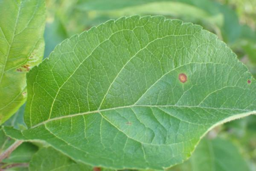

In [ ]:
sample_image = PILImage.create(files[0])
print(sample_image.size)
sample_image.to_thumb(256)

In [ ]:
from fastcore.parallel import *
def get_size(image):
  return PILImage.create(image).size

In [ ]:
sizes = parallel(get_size, files, progress=True)

In [ ]:
df = pd.read_csv(data_folder/'train.csv')
df.head()

,image,labels
0,train_image_1.jpg,powdery_mildew
1,train_image_2.jpg,scab
2,train_image_3.jpg,scab frog_eye_leaf_spot
3,train_image_4.jpg,powdery_mildew
4,train_image_5.jpg,complex


In [ ]:
def get_X(df):
  return data_folder/'train/train'/df['image']
def get_y(df):
  return df['labels'].split(' ')

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=get_X,
    get_y=get_y,
    splitter=RandomSplitter(seed=42)
    )

dsets = dblock.datasets(df)
dsets.train[15]

dsets.train.vocab

['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']

In [ ]:
dsets.train.vocab

['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=get_X,
    get_y=get_y,
    splitter=RandomSplitter(seed=42),
    item_tfms=Resize(400,method='squish')
    )

dsets = dblock.datasets(df)
dsets.train[3]

(PILImage mode=RGB size=600x400, TensorMultiCategory([0., 0., 0., 0., 0., 1.]))

In [ ]:
import os
os.cpu_count()
dls = dblock.dataloaders(df,bs=64,num_workers=8)

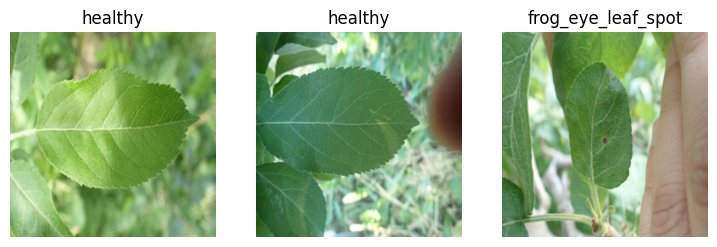

In [ ]:
dls.train.show_batch(max_n=3)

In [ ]:
dls.device

device(type='cuda', index=0)

In [ ]:
f1score = F1ScoreMulti(thresh=0.5)

In [ ]:
loss_func = nn.BCEWithLogitsLoss()

In [ ]:
learn = vision_learner(dls,'resnet26',metrics=[f1score],path=model_folder,loss_func=loss_func).to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26-9aa10e23.pth" to /root/.cache/torch/hub/checkpoints/resnet26-9aa10e23.pth


/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(minimum=0.03630780577659607, steep=0.02754228748381138, valley=0.0014454397605732083, slide=0.015848932787775993)

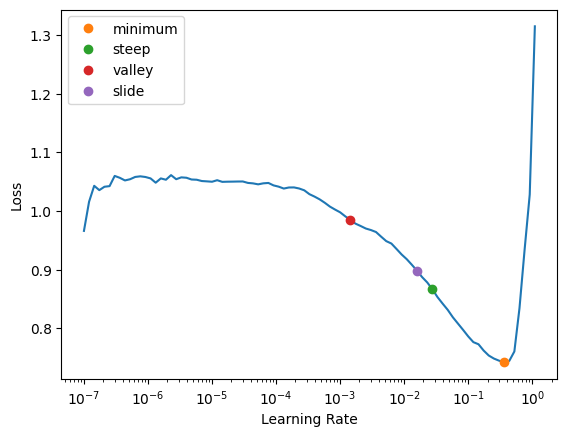

In [ ]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
learn.fine_tune(5,0.03)

epoch,train_loss,valid_loss,f1_score,time
0,0.286983,0.190093,0.806676,00:24


/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,f1_score,time
0,0.137549,0.127173,0.856940,00:27
1,0.109189,0.109301,0.853444,00:27
2,0.057463,0.138173,0.874989,00:27
3,0.026498,0.123231,0.889253,00:27
4,0.012155,0.122596,0.890467,00:27


In [ ]:
learn.metrics = F1ScoreMulti(thresh=0.1)

In [ ]:
learn.validate()

/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


(#2) [0.12259598821401596,0.8800886578308087]

In [ ]:
learn.metrics = F1ScoreMulti(thresh=0.9)
learn.validate()

/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


(#2) [0.12259598821401596,0.8657948518077297]

In [ ]:
preds, targs = learn.get_preds()
preds.shape, targs.shape

/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


(torch.Size([2608, 6]), torch.Size([2608, 6]))

In [ ]:
f1score = F1ScoreMulti(thresh=None,sigmoid=False)

In [ ]:
idxs = (preds>0.5)*1

In [ ]:
idxs

tensor([[0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1]])

In [ ]:
f1score(idxs,targs)

0.8890146136724774

In [ ]:
xs = torch.linspace(0.05,0.95,29)

In [ ]:
xs

tensor([0.0500, 0.0821, 0.1143, 0.1464, 0.1786, 0.2107, 0.2429, 0.2750, 0.3071,
        0.3393, 0.3714, 0.4036, 0.4357, 0.4679, 0.5000, 0.5321, 0.5643, 0.5964,
        0.6286, 0.6607, 0.6929, 0.7250, 0.7571, 0.7893, 0.8214, 0.8536, 0.8857,
        0.9179, 0.9500])

In [ ]:
fiscores = [f1score((preds>i)*1,targs) for i in xs]

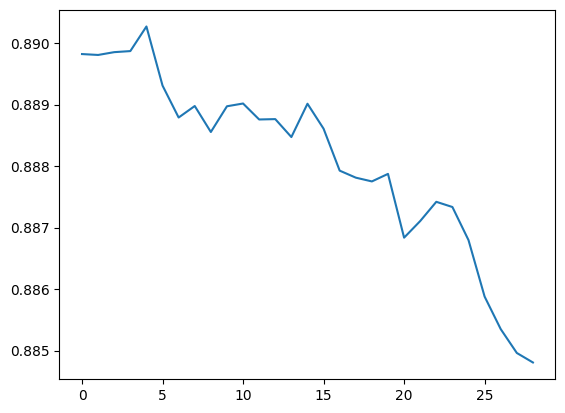

In [ ]:
plt.plot(fiscores)

In [ ]:
torch.argmax(torch.tensor(fiscores))

tensor(4)

In [ ]:
xs[4]

tensor(0.1786)

In [ ]:
fiscores[4]

0.890271015804564

In [ ]:
test_files = get_image_files(data_folder/'test/test').sorted()

In [ ]:
test_dl = learn.dls.test_dl(test_files)

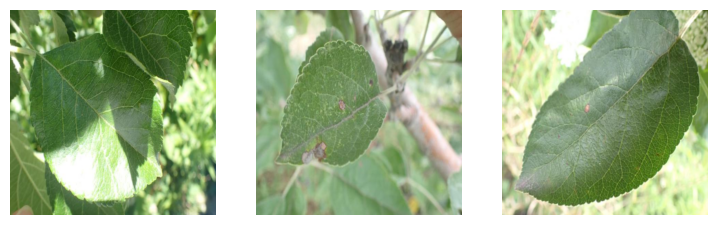

In [ ]:
test_dl.show_batch(max_n=3)

In [ ]:
preds, _ = learn.tta(dl=test_dl)

/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


In [ ]:
preds

tensor([[ -9.1953,  -9.3438,   1.0566,  -8.7266,  -7.8984,  -3.4395],
        [  2.1016,   0.4790,  -8.3672,  -4.2656,  -4.1094,  -1.6123],
        [ -6.2930,   8.7891, -10.6250, -10.9062, -11.4609,  -4.7344],
        ...,
        [-13.1172, -20.3438,  16.6875, -13.7109, -18.6250, -18.9688],
        [ -4.6680,   9.6484, -16.4219, -11.5391, -14.4766,  -7.2930],
        [ -5.8242, -12.9844, -11.7266,  11.8281, -12.3906, -12.0859]])

In [ ]:
pred_decoded = [torch.where(pred>0.1786)[0] for pred in preds]

In [ ]:
pred_decoded[0:20]

[tensor([2]),
 tensor([0, 1]),
 tensor([1]),
 tensor([1]),
 tensor([1, 4]),
 tensor([1]),
 tensor([1]),
 tensor([0, 1, 5]),
 tensor([0]),
 tensor([5]),
 tensor([2]),
 tensor([5]),
 tensor([2]),
 tensor([1]),
 tensor([5]),
 tensor([5]),
 tensor([4]),
 tensor([2]),
 tensor([2]),
 tensor([5])]

In [ ]:
vocab = learn.dls.vocab

In [ ]:
vocab

['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']

In [ ]:
pred_labels = [vocab[pred] for pred in pred_decoded]

In [ ]:
pred_labels = [" ".join(vocab[torch.where(pred>0.1786)[0]]) for pred in preds]

In [ ]:
sample_submission = pd.read_csv(data_folder/'sample_submission.csv')

In [ ]:
sample_submission = sample_submission.sort_values( by = 'image')

In [ ]:
sample_submission['labels'] = pred_labels

In [ ]:
#sample_submission.to_csv(model_folder/'rrk_first_submission.csv',index=False)

In [ ]:
#! head {model_folder/'rrk_first_submission.csv'}

image,labels
test_image_1.jpg,healthy
test_image_10.jpg,complex frog_eye_leaf_spot
test_image_100.jpg,frog_eye_leaf_spot
test_image_1000.jpg,frog_eye_leaf_spot
test_image_1001.jpg,frog_eye_leaf_spot rust
test_image_1002.jpg,frog_eye_leaf_spot
test_image_1003.jpg,frog_eye_leaf_spot
test_image_1004.jpg,complex frog_eye_leaf_spot scab
test_image_1005.jpg,complex


In [ ]:
#comp = 'inclass-plant-pathology-small-f-24'
#api.competition_submit(model_folder/'rrk_first_submission.csv', 'inclass_nov4', comp)

100%|██████████| 165k/165k [00:02<00:00, 75.0kB/s]


Successfully submitted to Inclass_Plant_Pathology_Small_F24